In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import zipfile

# with zipfile.ZipFile('/content/drive/MyDrive/pest-20250508T182454Z-001.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/pest')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
import os
import time

In [6]:
base_dir = 'data/pest'
# base_dir = '/content/drive/MyDrive/pest/pest'


train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [7]:
#No of Classes
train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))

if not train_classes:
    print("No class directories found in the train folder")
else:
    print(f"Found {len(train_classes)} classes: {train_classes}")

Found 9 classes: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


In [8]:
from PIL import Image, UnidentifiedImageError
import os

def clean_corrupted_images(directory):
    print(f"\nChecking: {directory}")
    deleted_count = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except (IOError, UnidentifiedImageError) as e:
                    print(f"Deleting corrupted image: {img_path} - Reason: {e}")
                    os.remove(img_path)
                    deleted_count += 1

    if deleted_count == 0:
        print("No corrupted images found.")
    else:
        print(f"Done. Deleted {deleted_count} corrupted image(s).")

# Run cleaning
clean_corrupted_images(train_dir)
clean_corrupted_images(test_dir)


Checking: data/pest\train
No corrupted images found.

Checking: data/pest\test
No corrupted images found.


In [10]:
import os

def count_images_per_class(base_dir, class_names):
    image_counts = {}
    total = 0
    for cls in class_names:
        class_path = os.path.join(base_dir, cls)
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])
        image_counts[cls] = num_images
        total += num_images
    return image_counts, total

# Get class names
train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))

# Count images
train_counts, total_train = count_images_per_class(train_dir, train_classes)
test_counts, total_test = count_images_per_class(test_dir, test_classes)

# Collect all unique classes (for safety, in case train/test differ)
all_classes = sorted(set(train_counts.keys()) | set(test_counts.keys()))

# Header
print("Images per Class")
print("=" * 59)
print(f"{'Class Name':<30}{'Train Images':>15}{'Test Images':>15}")
print("=" * 59)

# Rows
for cls in all_classes:
    train_num = train_counts.get(cls, 0)
    test_num = test_counts.get(cls, 0)
    print(f"{cls:<30}{train_num:>15}{test_num:>15}")

# Totals
print("=" * 59)
print(f"{'Total training images:':<30}{total_train}")
print(f"{'Total testing images:':<30}{total_test}")
print(f"{'Total images:':<30}{total_train + total_test}")

Images per Class
Class Name                       Train Images    Test Images
aphids                                    266             44
armyworm                                  223             43
beetle                                    291             50
bollworm                                  245             36
grasshopper                               277             46
mites                                     254             42
mosquito                                  295             50
sawfly                                    200             37
stem_borer                                181             36
Total training images:        2232
Total testing images:         384
Total images:                 2616


In [11]:
# Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 150, 150
IMG_CHANNELS = 3
BATCH_SIZE = 32

In [24]:
# Enhanced data augmentation to reduce overfitting
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increased from 15
    width_shift_range=0.2,  # Increased from 0.1
    height_shift_range=0.2,  # Increased from 0.1
    horizontal_flip=True,
    zoom_range=0.2,  # Added
    shear_range=0.2,  # Added
    validation_split=0.2
)

In [25]:
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

Found 1788 images belonging to 9 classes.


In [26]:
val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 444 images belonging to 9 classes.


In [27]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 384 images belonging to 9 classes.


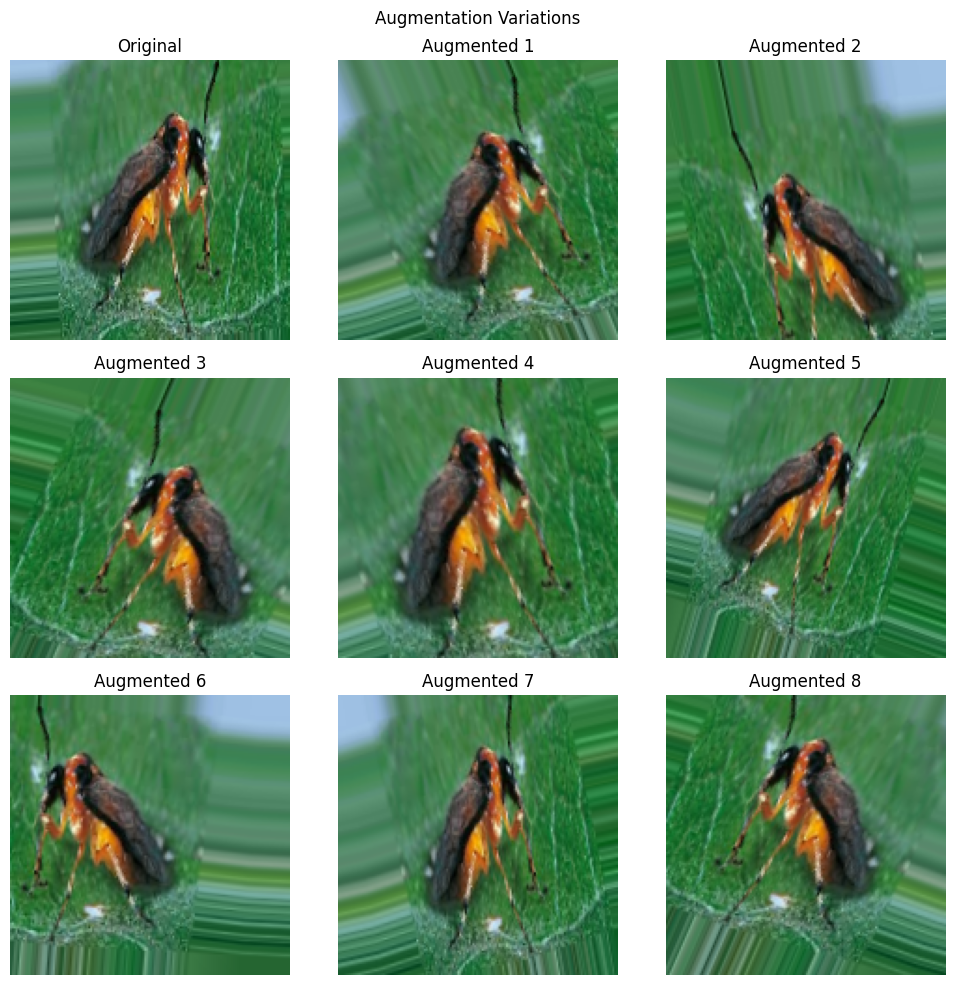

In [31]:
# Visualization-only generator (no rescale)
viz_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

sample_img, _ = next(train_gen)  # Get a batch
img = sample_img[0]

# Convert sample image back to uint8 for visualization
img_uint8 = (img * 255).astype(np.uint8)  # Assuming img was normalized

# Generate augmented images
augmented_images = [img_uint8]
for _ in range(8):
    aug_iter = viz_datagen.flow(np.expand_dims(img_uint8, axis=0), batch_size=1)
    aug_img = next(aug_iter)[0].astype(np.uint8)
    augmented_images.append(aug_img)

plt.figure(figsize=(10, 10))
for i, aug_img in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img)
    plt.axis('off')
    plt.title("Original" if i == 0 else f"Augmented {i}")
plt.suptitle("Augmentation Variations")
plt.tight_layout()
plt.show()


In [15]:
# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Number of classes: 9
Class names: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


In [16]:
# Compute class weights for imbalanced classes
labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.9327073552425665), 1: np.float64(1.1098696461824953), 2: np.float64(0.8526466380543634), 3: np.float64(1.0136054421768708), 4: np.float64(0.8948948948948949), 5: np.float64(0.9738562091503268), 6: np.float64(0.8418079096045198), 7: np.float64(1.2416666666666667), 8: np.float64(1.3701149425287356)}


In [17]:
# Show class distribution
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for cls, count in zip(unique, counts):
    print(f"Class {class_names[int(cls)]}: {count} samples")

Class distribution:
Class aphids: 213 samples
Class armyworm: 179 samples
Class beetle: 233 samples
Class bollworm: 196 samples
Class grasshopper: 222 samples
Class mites: 204 samples
Class mosquito: 236 samples
Class sawfly: 160 samples
Class stem_borer: 145 samples


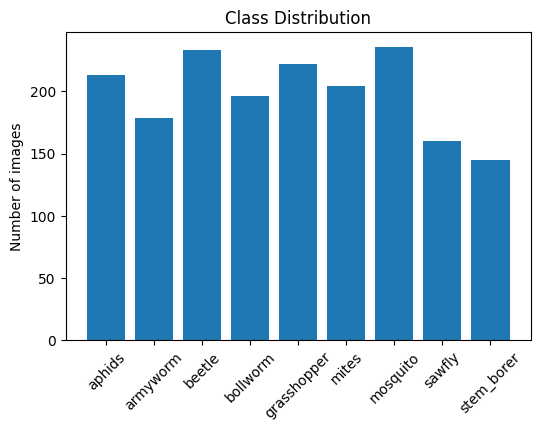

In [18]:
# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.ylabel("Number of images")
plt.show()

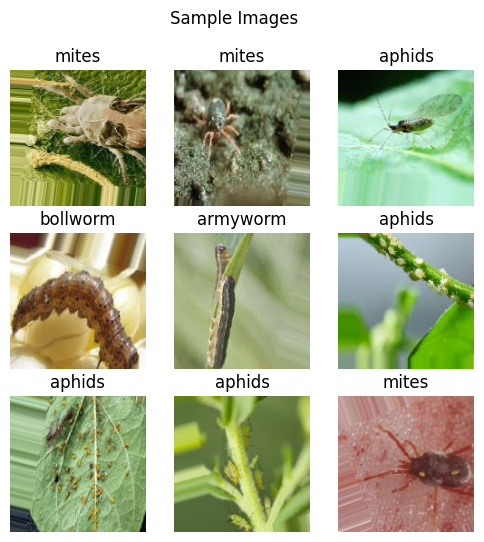

In [19]:
# Display sample images
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(class_names[int(y_batch[i])])
    plt.axis('off')
plt.suptitle("Sample Images")
plt.show()

In [20]:
# Define callbacks for underfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),  # Stop if val loss doesn't improve
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)  # Reduce LR on plateau
]

In [21]:
# Build baseline CNN with Dropout and L2 to reduce overfitting
model_baseline = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

In [22]:
# Compile model
model_baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,513 (18.42 MB)

 Trainable params: 4,829,513 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train model
history_baseline = model_baseline.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,  # Increased to address underfitting
    class_weight=class_weights_dict,  # Handle class imbalance
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 677ms/step - accuracy: 0.1322 - loss: 2.2297 - val_accuracy: 0.2432 - val_loss: 2.0634 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.2532 - loss: 2.0147 - val_accuracy: 0.2140 - val_loss: 2.0132 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.3040 - loss: 1.8769 - val_accuracy: 0.3243 - val_loss: 1.8483 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 0.3650 - loss: 1.7441 - val_accuracy: 0.3514 - val_loss: 1.8086 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step - accuracy: 0.4215 - loss: 1.6195 - val_accuracy: 0.3626 - val_loss: 1.7986 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 384ms/step - accuracy: 0.4507 - loss: 1.5404 - val_accuracy: 0.3356 - val_loss: 1.7860 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.4887 - l

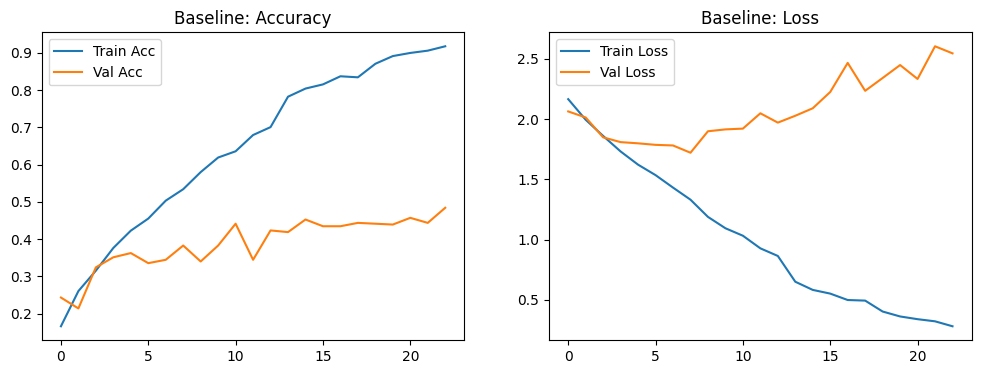

In [24]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Train Acc')
plt.plot(history_baseline.history['val_accuracy'], label='Val Acc')
plt.title("Baseline: Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Val Loss')
plt.title("Baseline: Loss")
plt.legend()
plt.show()

In [25]:
# Evaluate on test set
test_loss, test_acc = model_baseline.evaluate(test_gen, verbose=0)
print(f"Baseline Test Accuracy: {test_acc:.4f}")

Baseline Test Accuracy: 0.5156


In [26]:
# Predictions and classification report
y_pred_baseline = model_baseline.predict(test_gen)
y_pred_classes = np.argmax(y_pred_baseline, axis=1)
y_true = test_gen.classes
print("Classification Report (Baseline):")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step
Classification Report (Baseline):
              precision    recall  f1-score   support

      aphids       0.52      0.55      0.53        44
    armyworm       0.33      0.49      0.40        43
      beetle       0.60      0.80      0.68        50
    bollworm       0.43      0.69      0.53        36
 grasshopper       0.48      0.33      0.39        46
       mites       0.64      0.21      0.32        42
    mosquito       1.00      0.66      0.80        50
      sawfly       0.43      0.43      0.43        37
  stem_borer       0.34      0.33      0.34        36

    accuracy                           0.51       384
   macro avg       0.53      0.50      0.49       384
weighted avg       0.55      0.51      0.50       384



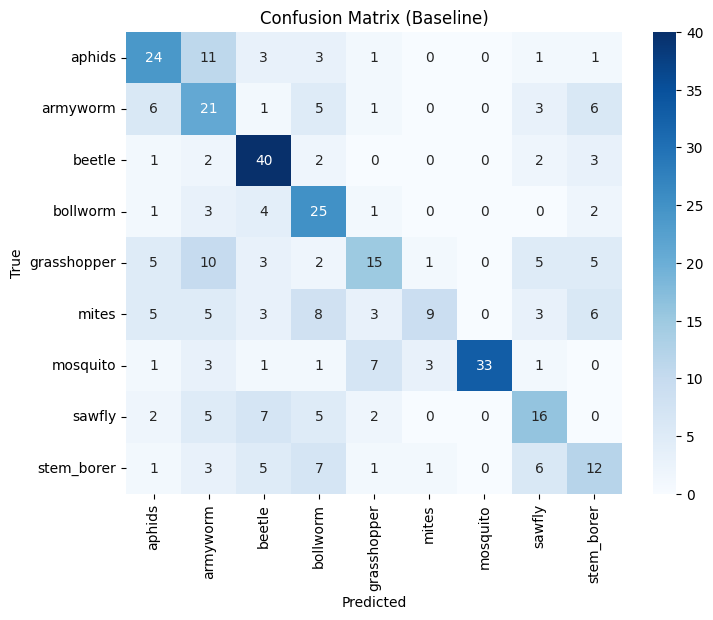

In [27]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (Baseline)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


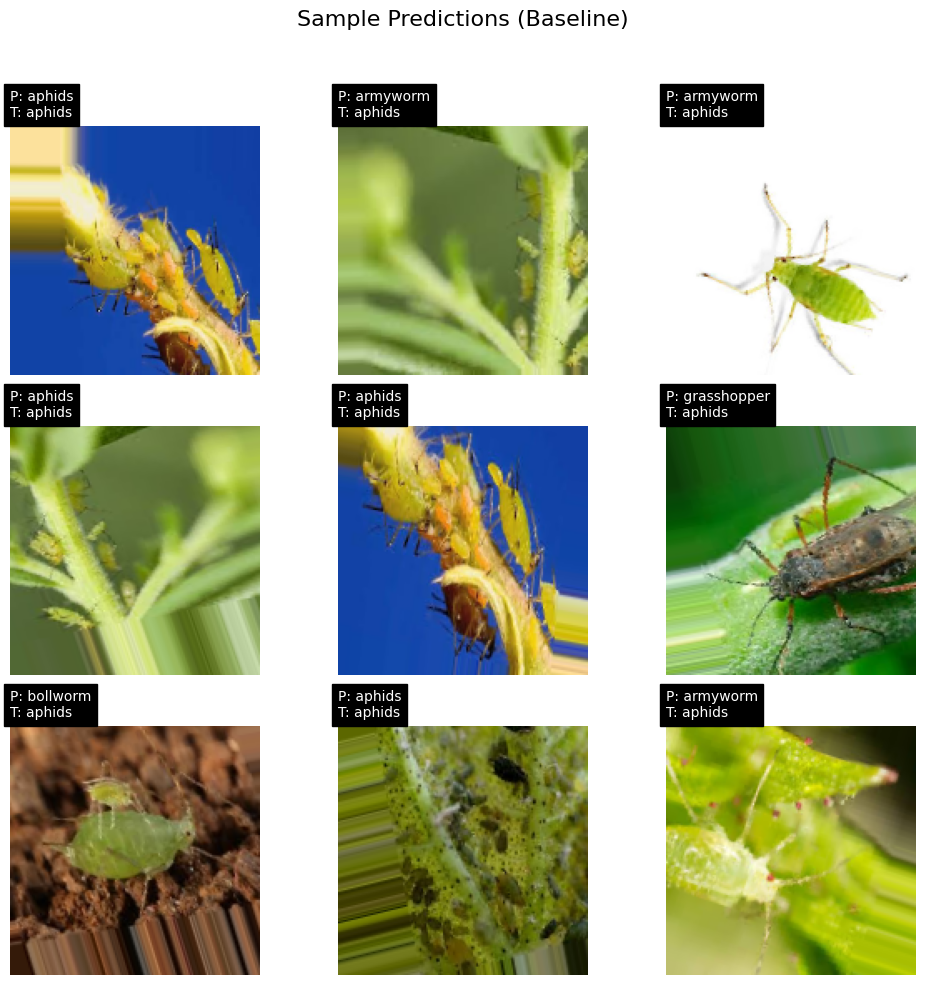

In [28]:
# Sample predictions
x_test_batch, y_test_batch = next(test_gen)
y_pred_batch = np.argmax(model_baseline.predict(x_test_batch), axis=1)

# Randomly shuffle indices within the batch to display different images each time
random_indices = np.random.permutation(x_test_batch.shape[0])[:9]  # Select 9 random indices from 0 to 31

plt.figure(figsize=(10, 10))  # Larger figure for clarity
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])

    pred_label = class_names[y_pred_batch[idx]]
    true_label = class_names[int(y_test_batch[idx])]

    # Use contrasting text with bounding box for better visibility
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10,
              color='white', backgroundcolor='black', loc='left')
    plt.axis('off')

plt.suptitle("Sample Predictions (Baseline)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

In [29]:
# Function to build deeper CNN with tuned regularization
def build_deeper_cnn():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),  # Increased L2
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),  # Reduced from 0.25
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Classifier
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),  # Simplified
        BatchNormalization(),
        Dropout(0.3),  # Reduced from 0.5
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [30]:
# Build and compile deeper model
model_deeper = build_deeper_cnn()
model_deeper.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_deeper.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 69, 69, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,977,001 (15.17 MB)

 Trainable params: 3,975,849 (15.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [32]:
epochs = 50
# Train deeper model
start = time.time()
history_deeper = model_deeper.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
print(f"Deeper model training time: {time.time() - start:.1f} seconds")

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - accuracy: 0.2780 - loss: 2.7695 - val_accuracy: 0.0946 - val_loss: 3.9182 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.3409 - loss: 2.6118 - val_accuracy: 0.1104 - val_loss: 4.1796 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step - accuracy: 0.4259 - loss: 2.3328 - val_accuracy: 0.1216 - val_loss: 4.0675 - learning_rate: 0.0010
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.4569 - loss: 2.2695 - val_accuracy: 0.1441 - val_loss: 3.7235 - learning_rate: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.4769 - loss: 2.1205 - val_accuracy: 0.1824 - val_loss: 3.5420 - learning_rate: 0.0010
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.5371 - loss: 1.9699 - val_accuracy: 0.1509 - val_loss: 3.5565 - learning_rate: 0.0010
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.5537 - loss: 1.

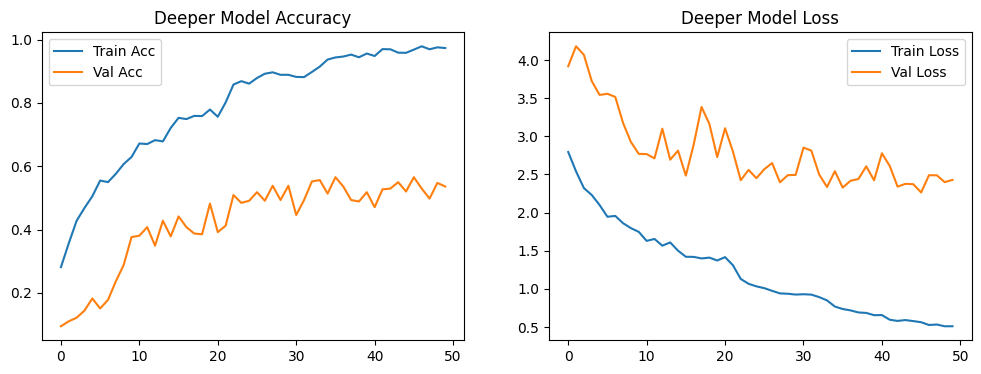

In [33]:
# Plot accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['accuracy'], label='Train Acc')
plt.plot(history_deeper.history['val_accuracy'], label='Val Acc')
plt.title("Deeper Model Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['loss'], label='Train Loss')
plt.plot(history_deeper.history['val_loss'], label='Val Loss')
plt.title("Deeper Model Loss")
plt.legend()
plt.show()

In [34]:
# Evaluate deeper model
test_loss_d, test_acc_d = model_deeper.evaluate(test_gen, verbose=0)
print(f"Deeper Model Test Accuracy: {test_acc_d:.4f}")

Deeper Model Test Accuracy: 0.8438


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step
Classification Report (Deeper):
              precision    recall  f1-score   support

      aphids       0.91      0.89      0.90        44
    armyworm       0.76      0.72      0.74        43
      beetle       0.94      0.96      0.95        50
    bollworm       0.80      0.97      0.88        36
 grasshopper       0.78      0.87      0.82        46
       mites       0.78      0.67      0.72        42
    mosquito       0.90      0.92      0.91        50
      sawfly       0.87      0.73      0.79        37
  stem_borer       0.86      0.86      0.86        36

    accuracy                           0.85       384
   macro avg       0.84      0.84      0.84       384
weighted avg       0.85      0.85      0.84       384



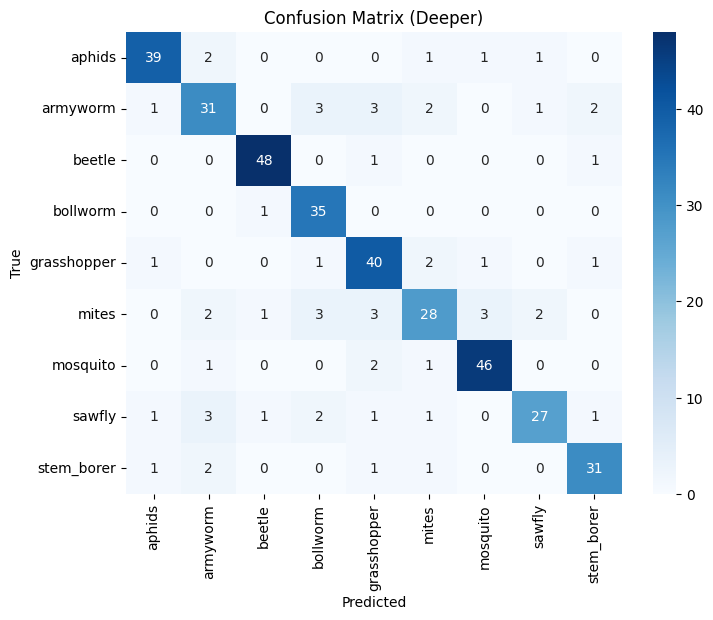

In [35]:
# Predictions
y_pred_deeper = np.argmax(model_deeper.predict(test_gen), axis=1)
print("Classification Report (Deeper):")
print(classification_report(y_true, y_pred_deeper, target_names=class_names))
cm_d = confusion_matrix(y_true, y_pred_deeper)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (Deeper)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


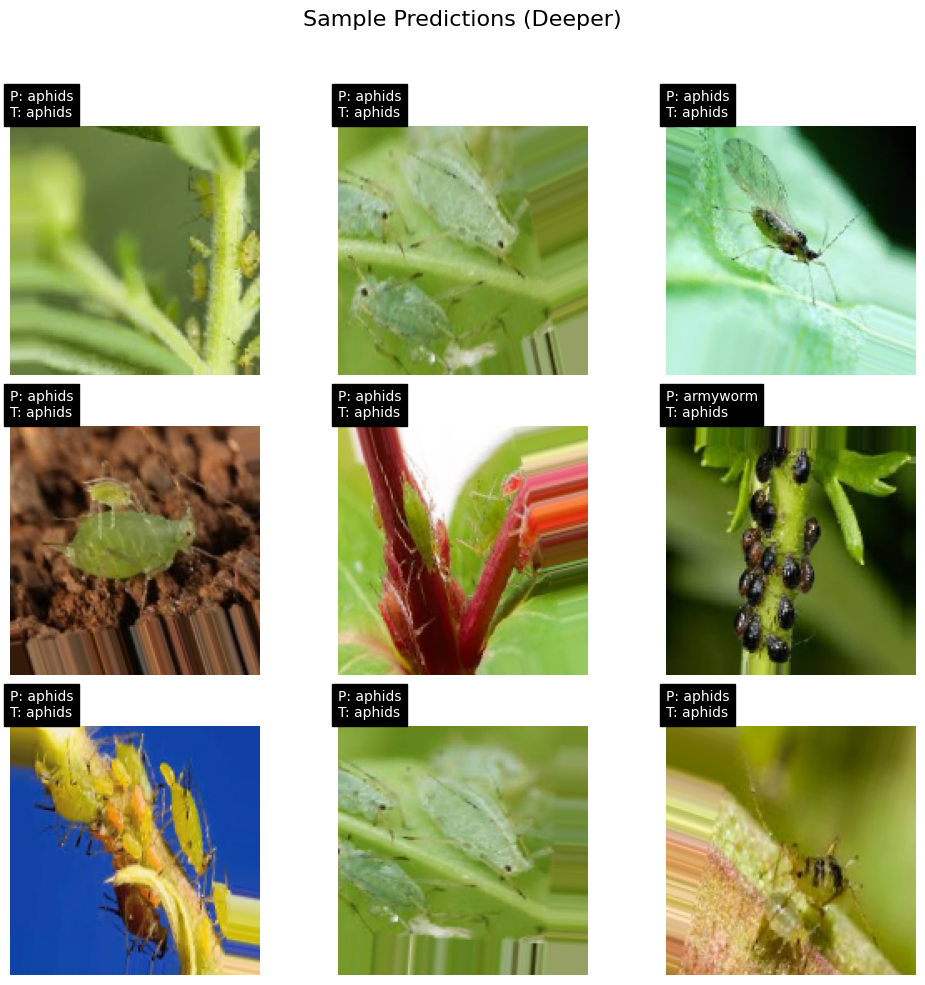

In [36]:
# Sample predictions (Deeper)
y_pred_batch = np.argmax(model_deeper.predict(x_test_batch), axis=1)

# Randomly shuffle indices within the batch to display different images each time
random_indices = np.random.permutation(x_test_batch.shape[0])[:9]  # Select 9 random indices from 0 to 31

plt.figure(figsize=(10, 10))  # Bigger size for better visibility
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])

    pred_label = class_names[y_pred_batch[idx]]
    true_label = class_names[int(y_test_batch[idx])]

    # Use white text on black background for clarity
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10,
              color='white', backgroundcolor='black', loc='left')
    plt.axis('off')

plt.suptitle("Sample Predictions (Deeper)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [37]:
from tensorflow.keras.optimizers import SGD

# Compare optimizers
adam_acc = test_acc_d

# Deeper model with SGD
model_deeper_sgd = build_deeper_cnn()
model_deeper_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
start = time.time()
history_sgd = model_deeper_sgd.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
sgd_time = time.time() - start
_, sgd_acc = model_deeper_sgd.evaluate(test_gen, verbose=0)
print(f"SGD Test Accuracy: {sgd_acc:.4f} (Time: {sgd_time:.1f}s)")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 625ms/step - accuracy: 0.1920 - loss: 3.2300 - val_accuracy: 0.1351 - val_loss: 38.3905 - learning_rate: 0.0100
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.2588 - loss: 2.7531 - val_accuracy: 0.1396 - val_loss: 5.1166 - learning_rate: 0.0100
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.3138 - loss: 2.5894 - val_accuracy: 0.2050 - val_loss: 3.1379 - learning_rate: 0.0100
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.3750 - loss: 2.3841 - val_accuracy: 0.2658 - val_loss: 2.6507 - learning_rate: 0.0100
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 398ms/step - accuracy: 0.4094 - loss: 2.2865 - val_accuracy: 0.2297 - val_loss: 2.7211 - learning_rate: 0.0100
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 398ms/step - accuracy: 0.4378 - loss: 2.2386 - val_accuracy: 0.3018 - val_loss: 2.6367 - learning_rate: 0.0100
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.4281 - 

In [38]:
# Report comparison
print(f"Baseline Test Accuracy: {test_acc:.4f}")
print(f"Deeper (Adam) Test Accuracy: {adam_acc:.4f}")
print(f"Deeper (SGD) Test Accuracy: {sgd_acc:.4f}")

Baseline Test Accuracy: 0.5156
Deeper (Adam) Test Accuracy: 0.8438
Deeper (SGD) Test Accuracy: 0.6510


In [39]:
# Summary table
import pandas as pd
results = pd.DataFrame({
    'Model': ['Baseline', 'Deeper (Adam)', 'Deeper (SGD)'],
    'Test Accuracy': [test_acc, adam_acc, sgd_acc]
})
print("\nSummary of Results:")
print(results)


Summary of Results:
           Model  Test Accuracy
0       Baseline       0.515625
1  Deeper (Adam)       0.843750
2   Deeper (SGD)       0.651042


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input

In [41]:
# Create new datagen for VGG16
datagen_vgg = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2,
    preprocessing_function=preprocess_input
)


In [42]:
# Initialize generators for transfer learning
train_gen_vgg = datagen_vgg.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

Found 1788 images belonging to 9 classes.


In [43]:
val_gen_vgg = datagen_vgg.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)


Found 444 images belonging to 9 classes.


In [44]:
test_gen_vgg = datagen_vgg.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 384 images belonging to 9 classes.


In [45]:
# Feature Extraction with VGG16
def build_vgg16_frozen():
    from tensorflow.keras.applications import VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    base_model.trainable = False
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


In [46]:
# Build and compile VGG16 model
model_vgg16_frozen = build_vgg16_frozen()
model_vgg16_frozen.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_vgg16_frozen.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,329 (56.64 MB)

 Trainable params: 133,641 (522.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [62]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('vgg16_frozen_best.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [64]:
epochs = 50
# Train VGG16 (feature extraction)
start_time = time.time()
history_vgg16_frozen = model_vgg16_frozen.fit(
    train_gen_vgg,
    validation_data=val_gen_vgg,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
vgg16_frozen_time = time.time() - start_time

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 438ms/step - accuracy: 0.8658 - loss: 0.3952 - val_accuracy: 0.7072 - val_loss: 1.3065 - learning_rate: 5.0000e-06
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - accuracy: 0.8771 - loss: 0.3775 - val_accuracy: 0.7027 - val_loss: 1.2465 - learning_rate: 5.0000e-06
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 435ms/step - accuracy: 0.9016 - loss: 0.3144 - val_accuracy: 0.7162 - val_loss: 1.3310 - learning_rate: 5.0000e-06
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - accuracy: 0.8919 - loss: 0.3367 - val_accuracy: 0.7162 - val_loss: 1.4074 - learning_rate: 5.0000e-06
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 421ms/step - accuracy: 0.8946 - loss: 0.3002 - val_accuracy: 0.7275 - val_loss: 1.4481 - learning_rate: 5.0000e-06
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 405ms/step - accuracy: 0.9047 - loss: 0.3146 - val_accuracy: 0.7230 - val_loss: 1.4212 - learning_rate: 2.5000e-06
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 421ms/step - acc

In [65]:
# Evaluate VGG16 model (frozen)
test_loss_vgg16_frozen, test_acc_vgg16_frozen = model_vgg16_frozen.evaluate(test_gen_vgg, verbose=0)
print(f"VGG16 Frozen Model Test Accuracy: {test_acc_vgg16_frozen:.4f}")

VGG16 Frozen Model Test Accuracy: 0.9036


In [66]:
# Evaluate VGG16 (feature extraction)
test_loss_vgg16_frozen, test_acc_vgg16_frozen = model_vgg16_frozen.evaluate(test_gen_vgg, verbose=0)
y_pred_vgg16_frozen = np.argmax(model_vgg16_frozen.predict(test_gen_vgg), axis=1)
y_true = test_gen_vgg.classes
print("Classification Report (VGG16 Frozen):")
print(classification_report(y_true, y_pred_vgg16_frozen, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step
Classification Report (VGG16 Frozen):
              precision    recall  f1-score   support

      aphids       0.83      0.86      0.84        44
    armyworm       0.87      0.79      0.83        43
      beetle       0.96      0.98      0.97        50
    bollworm       0.87      0.92      0.89        36
 grasshopper       0.98      0.98      0.98        46
       mites       0.90      0.86      0.88        42
    mosquito       0.96      0.96      0.96        50
      sawfly       0.89      0.84      0.86        37
  stem_borer       0.79      0.86      0.83        36

    accuracy                           0.90       384
   macro avg       0.89      0.89      0.89       384
weighted avg       0.90      0.90      0.90       384



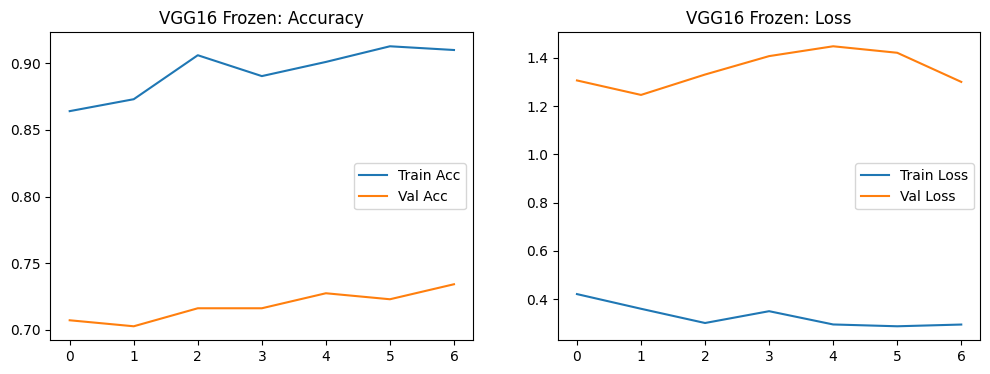

In [67]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_frozen.history['accuracy'], label='Train Acc')
plt.plot(history_vgg16_frozen.history['val_accuracy'], label='Val Acc')
plt.title("VGG16 Frozen: Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_vgg16_frozen.history['loss'], label='Train Loss')
plt.plot(history_vgg16_frozen.history['val_loss'], label='Val Loss')
plt.title("VGG16 Frozen: Loss")
plt.legend()
plt.show()

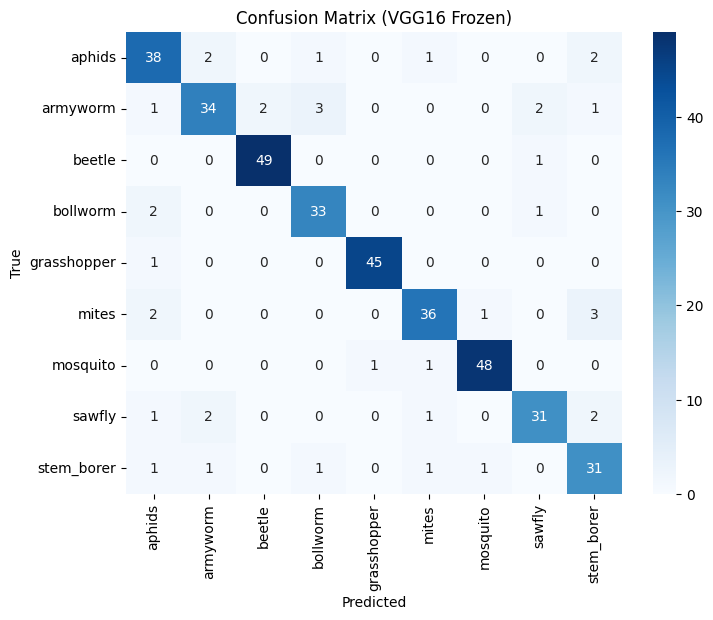

In [68]:
# Confusion matrix
cm_vgg16_frozen = confusion_matrix(y_true, y_pred_vgg16_frozen)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg16_frozen, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (VGG16 Frozen)")
plt.show()

In [69]:
# Fine-Tuning VGG16
base_model = model_vgg16_frozen.layers[1]
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 4
for layer in base_model.layers[-8:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


In [70]:
# Recompile with lower learning rate
model_vgg16_frozen.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [71]:
epochs = 50
# Fine-tune
start_time = time.time()
history_vgg16_finetuned = model_vgg16_frozen.fit(
    train_gen_vgg,
    validation_data=val_gen_vgg,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
vgg16_finetuned_time = time.time() - start_time

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 562ms/step - accuracy: 0.8627 - loss: 0.3992 - val_accuracy: 0.6959 - val_loss: 1.4685 - learning_rate: 1.0000e-05
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 430ms/step - accuracy: 0.8897 - loss: 0.2940 - val_accuracy: 0.7185 - val_loss: 1.3482 - learning_rate: 1.0000e-05
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.9095 - loss: 0.2647 - val_accuracy: 0.7072 - val_loss: 1.5185 - learning_rate: 1.0000e-05
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 438ms/step - accuracy: 0.9134 - loss: 0.2712 - val_accuracy: 0.7185 - val_loss: 1.1173 - learning_rate: 1.0000e-05
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 408ms/step - accuracy: 0.9478 - loss: 0.1577 - val_accuracy: 0.7027 - val_loss: 1.3462 - learning_rate: 1.0000e-05
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - accuracy: 0.9442 - loss: 0.1602 - val_accuracy: 0.7072 - val_loss: 1.4750 - learning_rate: 1.0000e-05
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 415ms/step - acc

In [72]:
test_loss_vgg16_finetuned, test_acc_vgg16_finetuned = model_vgg16_frozen.evaluate(test_gen_vgg, verbose=0)
print(f"VGG16 Fine-Tuned Model Test Accuracy: {test_acc_vgg16_finetuned:.4f}")

VGG16 Fine-Tuned Model Test Accuracy: 0.9323


In [73]:
# Evaluate VGG16 (fine-tuned)
test_loss_vgg16_finetuned, test_acc_vgg16_finetuned = model_vgg16_frozen.evaluate(test_gen_vgg, verbose=0)
y_pred_vgg16_finetuned = np.argmax(model_vgg16_frozen.predict(test_gen_vgg), axis=1)
print("Classification Report (VGG16 Fine-Tuned):")
print(classification_report(y_true, y_pred_vgg16_finetuned, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step
Classification Report (VGG16 Fine-Tuned):
              precision    recall  f1-score   support

      aphids       0.95      0.89      0.92        44
    armyworm       0.92      0.84      0.88        43
      beetle       1.00      0.98      0.99        50
    bollworm       0.83      0.97      0.90        36
 grasshopper       0.96      1.00      0.98        46
       mites       0.95      0.88      0.91        42
    mosquito       0.98      0.96      0.97        50
      sawfly       0.92      0.89      0.90        37
  stem_borer       0.83      0.94      0.88        36

    accuracy                           0.93       384
   macro avg       0.93      0.93      0.93       384
weighted avg       0.93      0.93      0.93       384



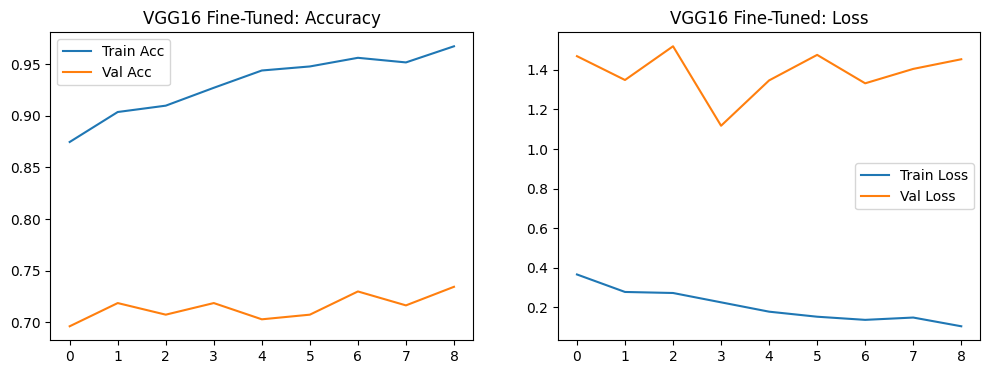

In [74]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_finetuned.history['accuracy'], label='Train Acc')
plt.plot(history_vgg16_finetuned.history['val_accuracy'], label='Val Acc')
plt.title("VGG16 Fine-Tuned: Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_vgg16_finetuned.history['loss'], label='Train Loss')
plt.plot(history_vgg16_finetuned.history['val_loss'], label='Val Loss')
plt.title("VGG16 Fine-Tuned: Loss")
plt.legend()
plt.show()

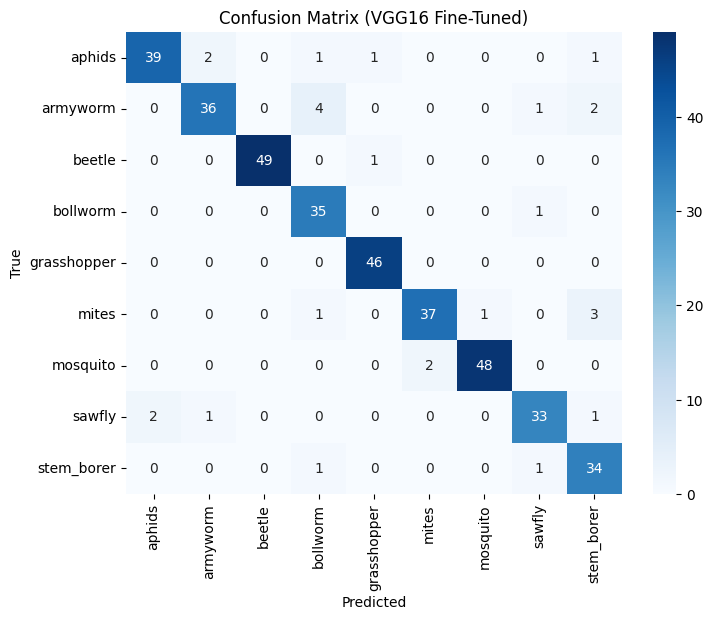

In [75]:
# Confusion matrix
cm_vgg16_finetuned = confusion_matrix(y_true, y_pred_vgg16_finetuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg16_finetuned, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (VGG16 Fine-Tuned)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


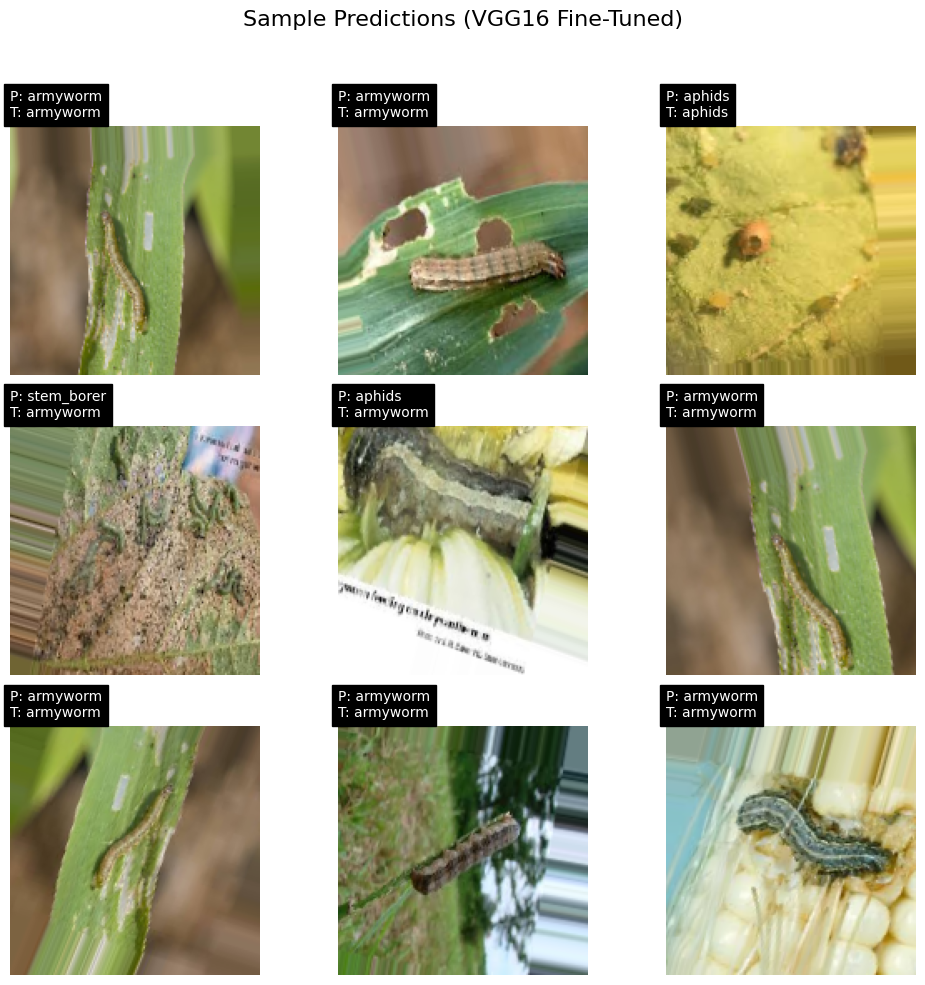

In [76]:
# Sample predictions (fixed for datagen_vgg without rescale)
x_test_batch, y_test_batch = next(test_gen_vgg)
y_pred_batch_vgg16 = np.argmax(model_vgg16_frozen.predict(x_test_batch), axis=1)

random_indices = np.random.permutation(x_test_batch.shape[0])[:9]
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    # Adjust image for display (undo preprocess_input)
    img = x_test_batch[idx]  # Shape: (height, width, 3), values zero-centered
    img = img + [103.939, 116.779, 123.68]  # Add ImageNet means (BGR)
    img = img[..., ::-1]  # BGR to RGB
    img = img / 255.0  # Scale to [0, 1] (input was [0, 255])
    img = img.clip(0, 1)  # Ensure valid range
    plt.imshow(img)
    pred_label = class_names[y_pred_batch_vgg16[idx]]
    true_label = class_names[int(y_test_batch[idx])]
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10, color='white', backgroundcolor='black', loc='left')
    plt.axis('off')
plt.suptitle("Sample Predictions (VGG16 Fine-Tuned)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [77]:
# Print all test accuracies
print(f"{'Model':<30} {'Optimizer':<10} {'Test Accuracy':<15}")
print("-" * 55)
# Baseline model
print(f"{'Baseline CNN':<30} {'Adam':<10} {test_acc:.4f}")

# Deeper CNN with Adam
print(f"{'Deeper CNN':<30} {'Adam':<10} {adam_acc:.4f}")

# Deeper CNN with SGD
print(f"{'Deeper CNN':<30} {'SGD':<10} {sgd_acc:.4f}")

# VGG16 (Frozen)
print(f"{'VGG16 (Frozen)':<30} {'Adam':<10} {test_acc_vgg16_frozen:.4f}")

# VGG16 (Fine-Tuned)
print(f"{'VGG16 (Fine-Tuned)':<30} {'Adam':<10} {test_acc_vgg16_finetuned:.4f}")


Model                          Optimizer  Test Accuracy  
-------------------------------------------------------
Baseline CNN                   Adam       0.5156
Deeper CNN                     Adam       0.8438
Deeper CNN                     SGD        0.6510
VGG16 (Frozen)                 Adam       0.9167
VGG16 (Fine-Tuned)             Adam       0.9115
